# NOTE!!!
- This is still in the context of tripadvisor reviews of waterfront
- when the datasets are complete (i.e. naa na ang data from other sites sa kana nga hotel), kay cleaning & preprocessing of data should be adjusted when loading the different .csv files and the naming convention sa preprocessed reviews.
- ^^ Example: `preprocessed_waterfront_reviews_booking.npz`, `preprocessed_waterfront_reviews_agoda.npz`, `preprocessed_waterfront_reviews_tripadvisor.npz`, `preprocessed_waterfront_reviews_klook.npz`
- for automation of processes, add a feat where you just type in the name of the hotel and it will automatically search and load up the necessary CSVs for that inputted hotel.
- all ratings will be normalized before sentiment analysis to a [0, 1] range

## Current issues:
- model is abnormal. it outputs all 1.0 no matter the negative threshold.
- model needs work

## Importing libraries

In [12]:
# Importing Libraries
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
import glob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Declarations

In [13]:
# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

## Cleaning & Preprocessing

In [14]:
def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        # Get all CSV files in the source folder
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"Found {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                # Load the dataset
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"Processing file: {file_path} with {reviews.shape[0]} rows")
                
                # Check if the required columns are present
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                # Remove irrelevant columns
                columns_to_keep = ['Review Content', 'Review Score', 'Review Time']
                reviews = reviews[columns_to_keep]
                
                # Remove missing values
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                # Extract numeric rating from textual ratings if necessary
                reviews['Review Score'] = reviews['Review Score'].apply(extract_numeric_rating)
                print(f"After extracting numeric ratings: {reviews.shape[0]} rows")
                
                # Normalize ratings to a common scale (0 to 1)
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                # Language detection and filtering for English reviews
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                # Remove HTML tags if necessary
                reviews['Review Content'] = reviews['Review Content'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
                print(f"After removing HTML tags: {reviews.shape[0]} rows")
                
                # Remove duplicates
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                # Text preprocessing: convert to lowercase, remove punctuation, remove stopwords, and lemmatize
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                # Append to the list of all reviews
                all_reviews.append(reviews)

    # Combine all reviews into a single DataFrame
    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Prepare labels
    labels = combined_reviews['Review Score'].values

    # Split data into training and testing sets (70/30)
    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

    # Save the preprocessed and vectorized dataset along with indices
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, x_test_indices=np.arange(len(x_test)))

    # Variable Identification
    x = combined_reviews['Review Content']
    y_ground_truth = combined_reviews['Review Score']

    # Vectorization using Word2Vec
    sentences = [review.split() for review in x]
    word2vec_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

    # Generate word vectors with consistent lengths
    x_vectorized = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv] or [np.zeros(EMBEDDING_DIM)], axis=0) for review in x])
    
    # Vectorization using Doc2Vec
    tagged_data = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(x)]
    doc2vec_model = Doc2Vec(tagged_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
    x_doc2vec = np.array([doc2vec_model.infer_vector(review.split()) for review in x])

    # Normalize sentiment labels (y)
    y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    # Sentiment Label Preprocessing
    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    # Add sentiment labels to the DataFrame for clarity
    combined_reviews['Sentiment Label'] = y_labels

    # Save preprocessed variables
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, 
                        x_vectorized=x_vectorized, x_doc2vec=x_doc2vec, y_labels=y_labels, x_test_indices=np.arange(len(x_test)))

    # Verify shapes
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_vectorized shape: {x_vectorized.shape}")
    print(f"x_doc2vec shape: {x_doc2vec.shape}")
    print(f"y_labels shape: {y_labels.shape}")

## Data preparation

In [15]:
# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    # Mapping hotel names to numbered output folder names
    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        process_reviews(hotel_name, source_folders, output_folder)

if __name__ == "__main__":
    main()

Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel
Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After extracting numeric ratings: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 0 rows
After removing HTML tags: 0 rows
After removing duplicates: 0 rows
After text preprocessing: 0 rows
Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel
Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After extracting numeric ratings: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 0 rows
After removing HTML tags: 0 rows
After removing duplicates: 0 rows
After text preprocessing: 0 rows
Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel
Processing file: ..\raw data\klook_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1

## EDA

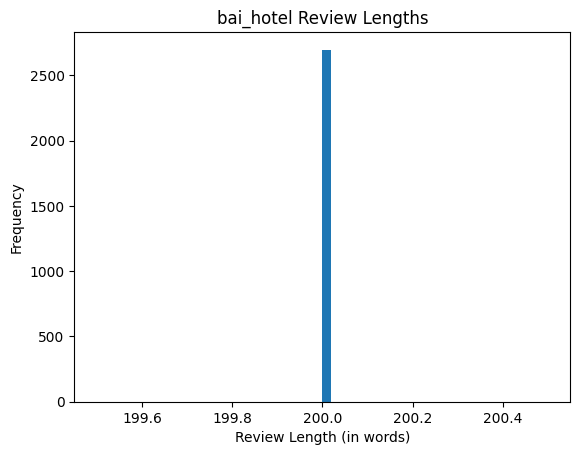

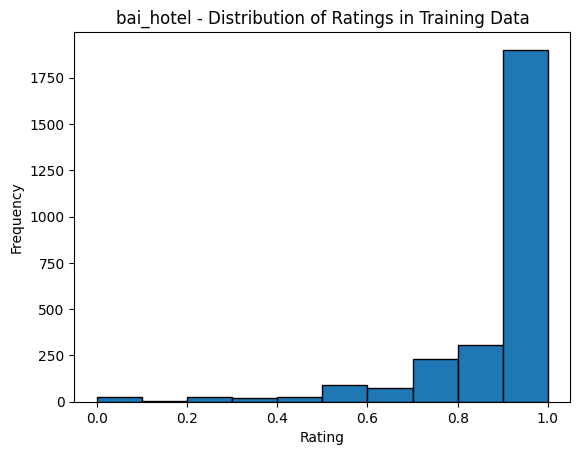

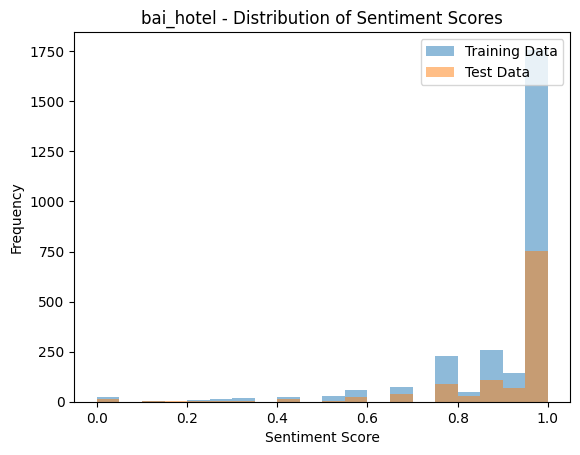

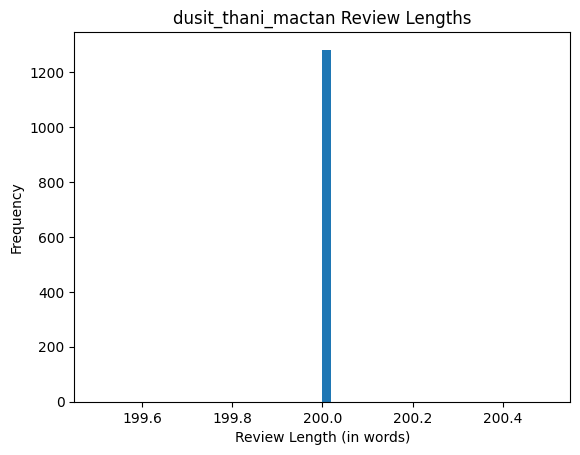

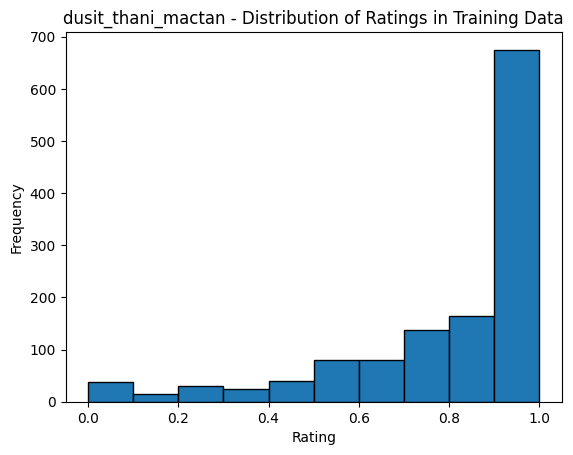

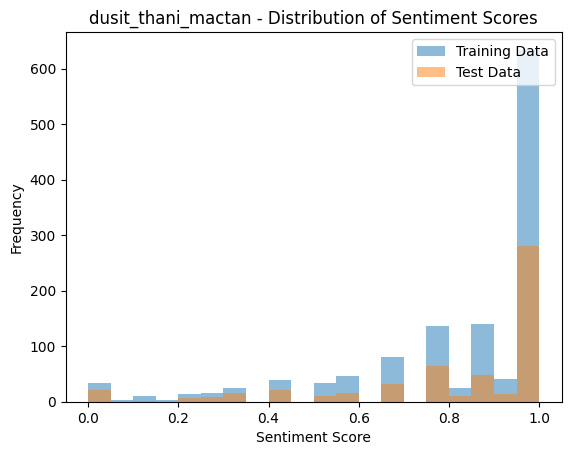

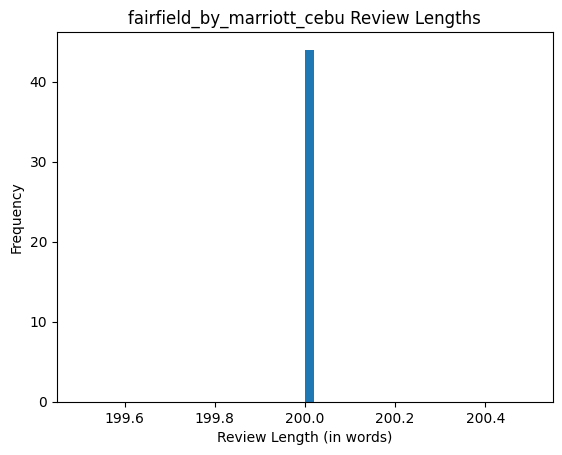

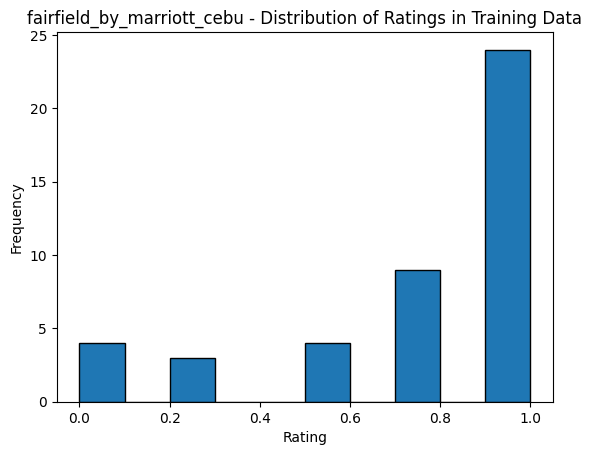

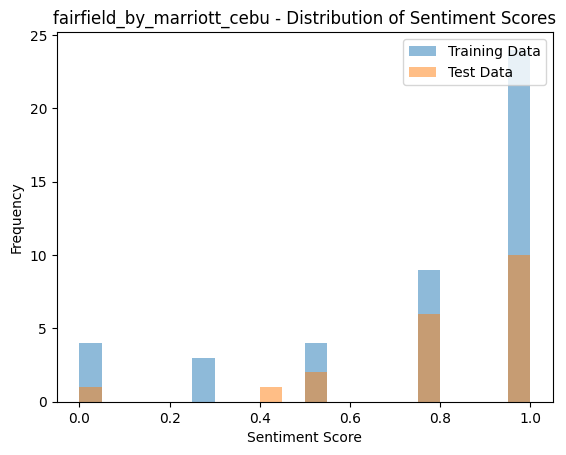

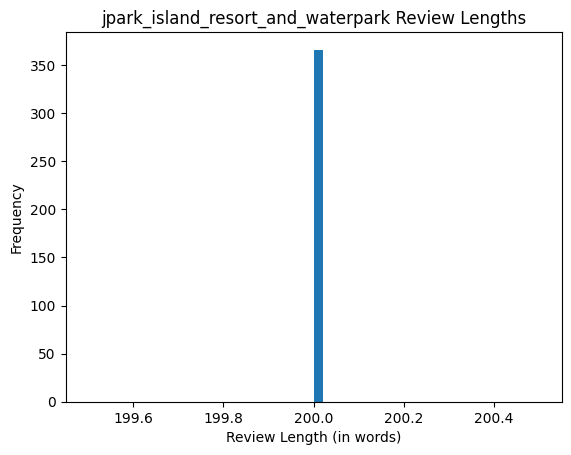

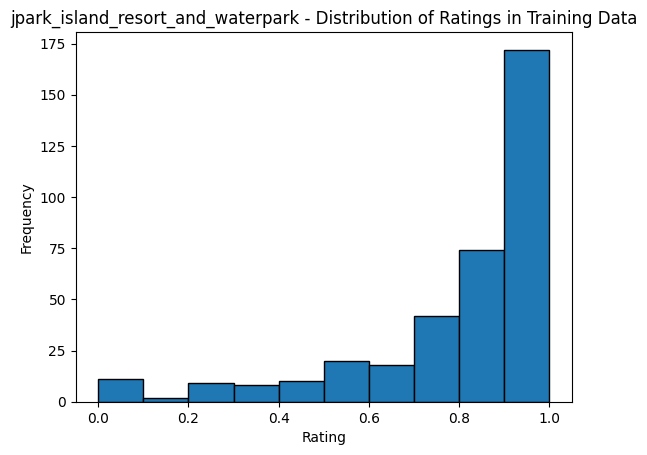

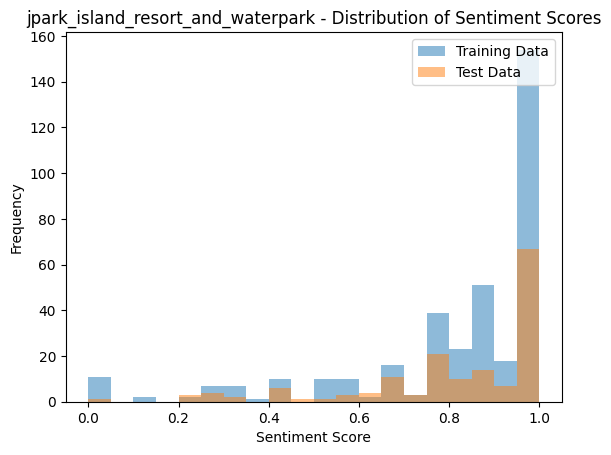

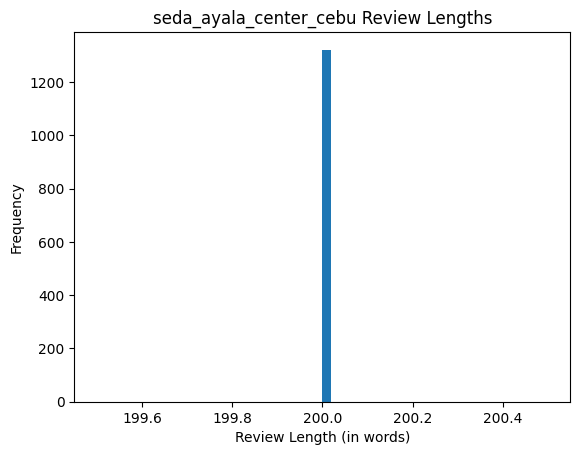

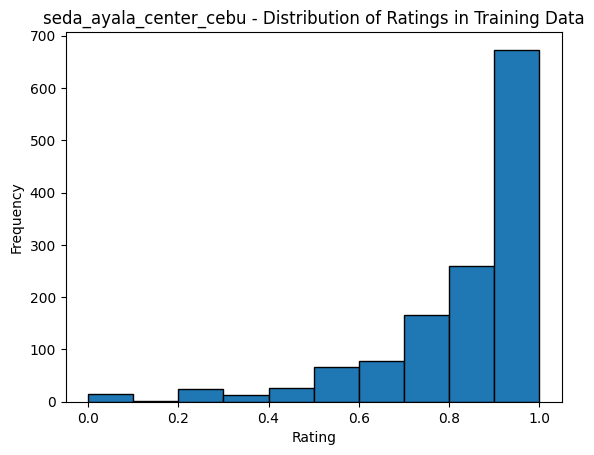

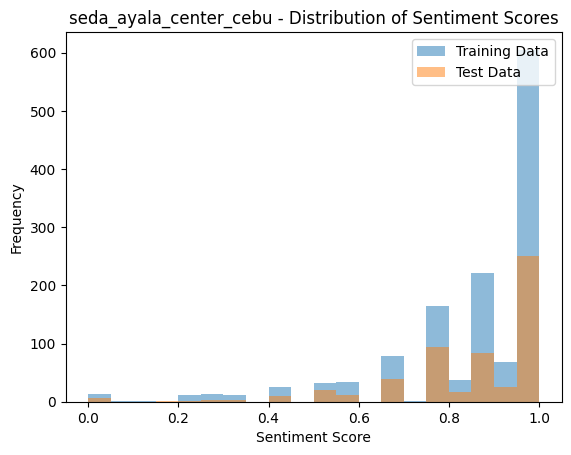

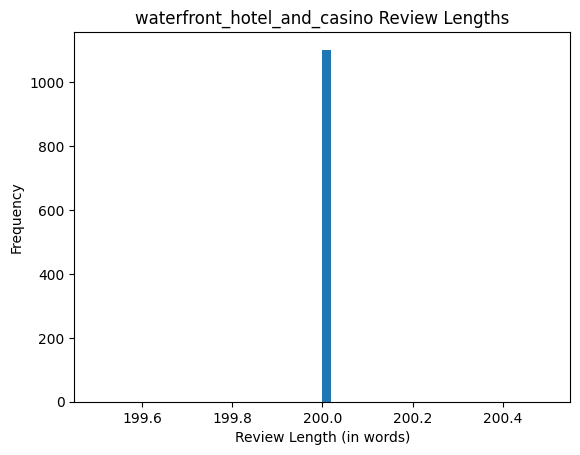

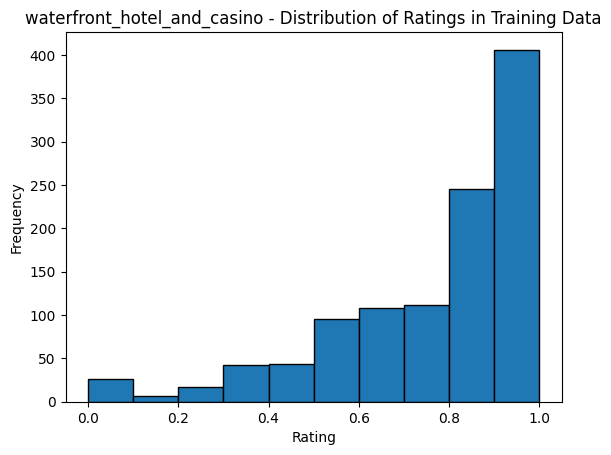

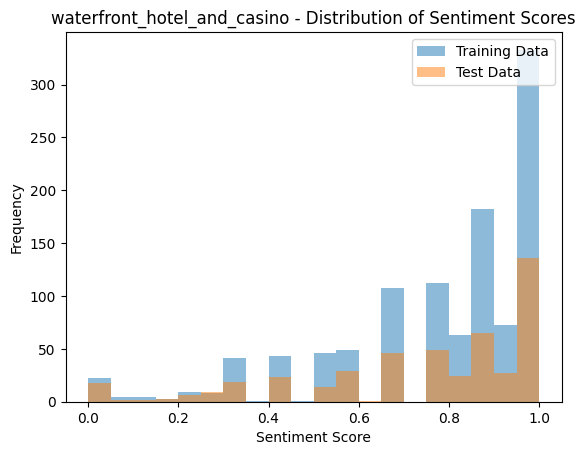

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the base path for datasets
base_output_path = os.path.join('..', 'datasets')

# List of hotel folders and their corresponding names for the EDA plots
hotel_folders = {
    '1_bai_hotel': 'bai_hotel',
    '2_dusit_thani_mactan': 'dusit_thani_mactan',
    '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
    '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
    '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
    '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
}

for folder, hotel_name in hotel_folders.items():
    output_folder = os.path.join(base_output_path, folder)
    
    # Load the preprocessed data
    data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # For EDA purposes only
    # Review lengths
    review_lengths = [len(review) for review in x_train]
    plt.hist(review_lengths, bins=50)
    plt.title(f'{hotel_name} Review Lengths')
    plt.xlabel('Review Length (in words)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Distribution of Ratings in Training Data
    plt.hist(y_train, bins=10, edgecolor='k')
    plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()
    
    # Distribution of Sentiment Scores
    plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
    plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
    plt.legend(loc='upper right')
    plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()


## Model training part

In [17]:
#! OLD VERSION OF MODEL CODE
# # Calculate class weights
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                   classes=np.unique(y_train), 
#                                                   y=y_train)

# # Create a dictionary to use in model training
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# # Compute sample weights
# sample_weights = np.array([class_weights_dict[int(y)] for y in y_train])

# # Define the model architecture with Dropout
# input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
# conv = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
# pool = MaxPooling1D(pool_size=2)(conv)
# bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(pool)
# dropout = Dropout(0.5)(bi_lstm)
# flat = Flatten()(dropout)

# # Output layer for general sentiment
# sentiment_output = Dense(1, activation='sigmoid', name='sentiment_output')(flat)

# # Output layer for aspect-based sentiment
# aspect_output = Dense(len(mlb.classes_), activation='softmax', name='aspect_output')(flat)

# # Define the model
# model = Model(inputs=input_text, outputs=[sentiment_output, aspect_output])

# # Compile the model with mean squared error loss for sentiment analysis
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss={'sentiment_output': 'mse', 'aspect_output': 'categorical_crossentropy'},
#               metrics={'sentiment_output': 'mae', 'aspect_output': 'accuracy'})

# # Callback to monitor training
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.weights.h5', save_best_only=True, save_weights_only=True)
# ]

# # Train the model using aspect-based data for aspect prediction
# print("Training the model using aspect-based data for aspect prediction...")
# model.fit(x_train_aspects,
#           {'sentiment_output': np.zeros(len(x_train_aspects)), 'aspect_output': y_train_aspects},
#           validation_data=(x_val_aspects, {'sentiment_output': np.zeros(len(x_val_aspects)), 'aspect_output': y_val_aspects}),
#           epochs=EPOCHS,
#           batch_size=BATCH_SIZE,
#           callbacks=callbacks)

# # Train the model using hotel reviews for general sentiment prediction
# print("Training the model using hotel reviews for general sentiment prediction...")
# history = model.fit(x_train,
#                     {'sentiment_output': y_train, 'aspect_output': np.zeros((len(x_train), len(mlb.classes_)))},
#                     validation_data=(x_test, {'sentiment_output': y_test, 'aspect_output': np.zeros((len(x_test), len(mlb.classes_)))}),
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     callbacks=callbacks,
#                     sample_weight=sample_weights)

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Training CNN-biLSTM Model...


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.3020 - loss: 0.5664 - val_accuracy: 0.3243 - val_loss: 0.4780
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2698 - loss: 0.5244 - val_accuracy: 0.3243 - val_loss: 0.4590
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3078 - loss: 0.4611 - val_accuracy: 0.3243 - val_loss: 0.4534
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3100 - loss: 0.4401 - val_accuracy: 0.3333 - val_loss: 0.4455
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2953 - loss: 0.4043 - val_accuracy: 0.3243 - val_loss: 0.4463
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3170 - loss: 0.3876 - val_accuracy: 0.3333 - val_loss: 0.4449
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3067 - loss: 0.3851 - val_accuracy: 0.3333 - val_loss: 0.4516
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2988 - loss: 0.3824 - val_accuracy: 0.3243 -

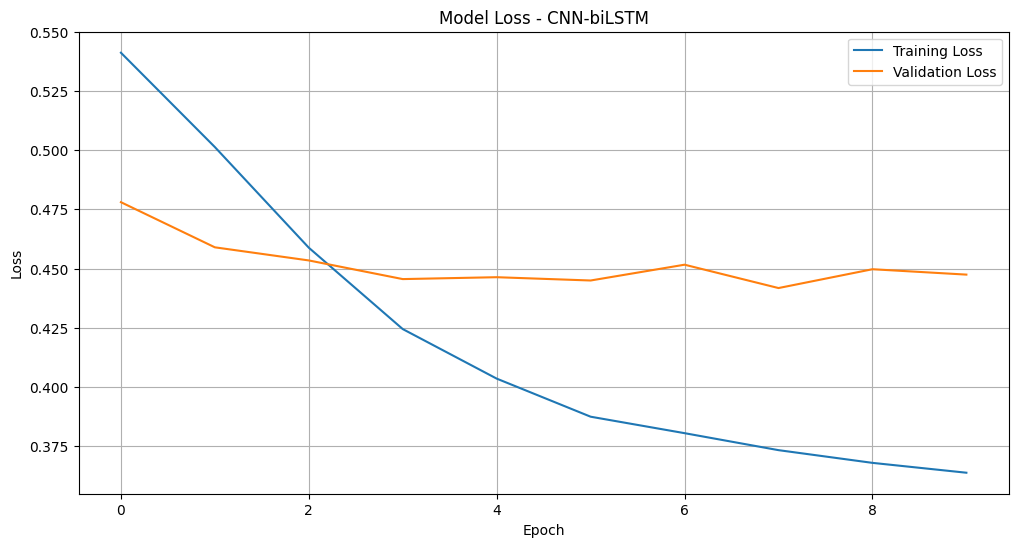

In [18]:
# Model Training - CNN-biLSTM
print("Training CNN-biLSTM Model...")
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
conv1d = Conv1D(128, 5, activation='relu')(embedding)
maxpool = MaxPooling1D(2)(conv1d)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
dropout = Dropout(0.5)(bi_lstm)
flat = Flatten()(dropout)
sentiment_output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=input_text, outputs=sentiment_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - CNN-biLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Model Training - Aspect-Based biLSTM
print("Training Aspect-Based biLSTM Model...")

# Load Aspect Data
aspect_files = glob.glob(r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv")
aspect_data = pd.concat((pd.read_csv(file) for file in aspect_files), ignore_index=True)

# Ensure all entries in 'Classification' are strings and handle missing values
aspect_data['Classification'] = aspect_data['Classification'].fillna('')  # Replace NaN with empty strings
aspect_data['Classification'] = aspect_data['Classification'].apply(lambda x: x.split(':') if isinstance(x, str) else [])

# Binarize labels
mlb = MultiLabelBinarizer()
aspect_labels = mlb.fit_transform(aspect_data['Classification'])

# Tokenize and pad sequences
aspect_reviews = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_reviews_padded = pad_sequences(aspect_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Split Aspect Data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_reviews_padded, aspect_labels, test_size=0.3, random_state=42)

# Define Model
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
dropout_aspect = Dropout(0.5)(bi_lstm_aspect)
output_aspect = Dense(mlb.classes_.shape[0], activation='softmax')(dropout_aspect)
model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_aspects, y_train_aspects, validation_data=(x_test_aspects, y_test_aspects),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Aspect-based biLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training Aspect-Based biLSTM Model...


NameError: name 'tokenizer' is not defined

## Checking of.npz file contents

In [ ]:
# Load the .npz file
general_sentiment_preds_file_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\results\waterfront_general_sentiment_predictions.npz"
general_sentiment_preds_data = np.load(general_sentiment_preds_file_path)

preprocessed_reviews_file_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\preprocessed_waterfront_reviews.npz"
preprocessed_reviews_data = np.load(preprocessed_reviews_file_path)

# Display the contents of the .npz file
print("Contents of the waterfront_general_sentiment_predictions.npz file:")
print(general_sentiment_preds_data.files)

# Convert the arrays to pandas DataFrames for tabular display
for array_name in general_sentiment_preds_data.files:
    array_data = general_sentiment_preds_data[array_name]
    print(f"\nArray Name: {array_name}")
    
    if array_data.ndim == 1:
        df = pd.DataFrame(array_data, columns=[array_name])
    else:
        df = pd.DataFrame(array_data)
    
        # Filter and display rows where the values are not 1.0
    filtered_df = df[df.iloc[:, 0] != 1.0]
    if not filtered_df.empty:
        print(f"\nFiltered {array_name} values that are not 1.0:")
        print(filtered_df.head())  # Display the first few rows of the filtered DataFrame
    else:
        print(f"\nNo values in {array_name} are different from 1.0")


# Display the contents of the .npz file
print("\nContents of the preprocessed_waterfront_reviews.npz file:")
print(preprocessed_reviews_data.files)

# Convert the arrays to pandas DataFrames for tabular display
for array_name in preprocessed_reviews_data.files:
    array_data = preprocessed_reviews_data[array_name]
    print(f"\nArray Name: {array_name}")
    
    if array_data.ndim == 1:
        df = pd.DataFrame(array_data, columns=[array_name])
    else:
        df = pd.DataFrame(array_data)
    
    print(df.head())  # Display the first few rows of the DataFrame

Contents of the waterfront_general_sentiment_predictions.npz file:
['sentiment_predictions']

Array Name: sentiment_predictions

Filtered sentiment_predictions values that are not 1.0:
   sentiment_predictions
0               0.999454

Contents of the preprocessed_waterfront_reviews.npz file:
['x_train', 'x_test', 'y_train', 'y_test', 'x_test_indices']

Array Name: x_train
   0    1    2    3    4    5    6    7    8    9    ...   190   191   192  \
0    0    0    0    0    0    0    0    0    0    0  ...     8  4894   346   
1    0    0    0    0    0    0    0    0    0    0  ...    54  6586   144   
2    0    0    0    0    0    0    0    0    0    0  ...  2292   800    92   
3    0    0    0    0    0    0    0    0    0    0  ...    96    39    14   
4    0    0    0    0    0    0    0    0    0    0  ...    11   247  1689   

    193  194   195   196  197   198  199  
0     3    4     1  1066  426  4895  536  
1    54    4  2843    13  215    66  135  
2    15   93   310   172  

## Statictical Analysis

In [ ]:
# Load sentiment predictions
predictions_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\results\waterfront_general_sentiment_predictions.npz"
data = np.load(predictions_path, allow_pickle=True)
sentiment_predictions = data['sentiment_predictions']

# Load the original review texts
original_review_texts_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\tripadvisor\1_Waterfront-Cebu-City-Hotel-Casino.csv"
original_reviews_df = pd.read_csv(original_review_texts_path)

# Load indices
preprocessed_data_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\preprocessed_waterfront_reviews.npz"
indices_data = np.load(preprocessed_data_path)
x_test_indices = indices_data['x_test_indices']

print(f"Number of sentiment predictions: {len(sentiment_predictions)}")
print(f"Number of indices: {len(x_test_indices)}")

if len(sentiment_predictions) != len(x_test_indices):
    raise ValueError("The number of sentiment predictions does not match the number of indices.")

# Align data using indices
aligned_reviews_df = original_reviews_df.iloc[x_test_indices]

# Combine sentiment predictions with aligned review texts
waterfront_reviews = pd.DataFrame({
    'Review Text': aligned_reviews_df['Review Text'],
    'SA': sentiment_predictions.flatten()
})

# Ensure no length issues
if len(waterfront_reviews) != len(sentiment_predictions):
    raise ValueError("Mismatch between aligned reviews and sentiment predictions.")


# Combine sentiment predictions with review texts
waterfront_reviews = pd.DataFrame({'Review Text': original_reviews_df['Review Text'], 'SA': sentiment_predictions.flatten()})

# Define a function to plot KDE and peak using statsmodels
def plot_sa_distribution(df, hotel_name):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['SA'], shade=True, color='blue', label='SA Distribution')
    plt.title(f'Sentiment Analysis Distribution for {hotel_name}')
    plt.xlabel('Sentiment Analysis Score')
    plt.ylabel('Density')

    # Calculate KDE using statsmodels
    kde = KDEUnivariate(df['SA'])
    kde.fit(kernel='gau', bw='scott', gridsize=1000)
    density_values = kde.density
    support = kde.support
    peak_value = support[density_values.argmax()]
    plt.axvline(x=peak_value, linestyle='--', color='green', label=f'Peak: {round(peak_value, 2)}')

    # Add quartile lines
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} - {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.legend()
    plt.grid(True)
    plt.show()

    return peak_value

def save_results(hotel_name, peak_value):
    output_folder = "statistical_model_results"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create a file path for saving the results
    output_filename = os.path.join(output_folder, f"{hotel_name}_results.txt")

    # Determine which quartile the peak belongs to
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    peak_quartile = None
    for label, (start, end) in quartile_ranges.items():
        if start <= peak_value <= end:
            peak_quartile = label
            break

    # Open the file in write mode and save the results
    with open(output_filename, "w") as file:
        file.write(f"{hotel_name} Peak Value: {peak_value}\n")
        file.write(f"{hotel_name} Peak Quartile Classification: {peak_quartile}\n")

# Plot KDE and peak for Waterfront Hotel
waterfront_peak_value = plot_sa_distribution(waterfront_reviews, 'Waterfront Hotel')

# Save the results
save_results("Waterfront Hotel", waterfront_peak_value)

Number of sentiment predictions: 1
Number of indices: 517


ValueError: The number of sentiment predictions does not match the number of indices.

## Additional EDA

In [ ]:
# Predict sentiment on the test set
sentiment_predictions_binary = (sentiment_predictions > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, sentiment_predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_binary, sentiment_predictions_binary, target_names=['Negative', 'Positive'])
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[  0 152]
 [  0 365]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       152
    Positive       0.71      1.00      0.83       365

    accuracy                           0.71       517
   macro avg       0.35      0.50      0.41       517
weighted avg       0.50      0.71      0.58       517



c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo